# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# информация о договоре
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')

# персональные данные клиента;
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')

# информация об интернет-услугах;
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')

# информация об услугах телефонии.
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def df_inf(df):
    print(df.head(15))
    print("  ")
    print(df.info())
    print(" ")
    print('Количество пропущенных значений:',df.isnull().sum().values.sum())
    print(" ")
    print("Уникалье значения:")
    print(df.nunique())
    print(" ")
    print('Количество наблюдений:',df.shape[0], 'Количество признаков', df.shape[1])
    print(" ")
    print('Количество дублированных строк:',df.duplicated().sum())

### Персональные данные клиента

In [4]:
df_inf(df_personal)

    customerID  gender  SeniorCitizen Partner Dependents
0   7590-VHVEG  Female              0     Yes         No
1   5575-GNVDE    Male              0      No         No
2   3668-QPYBK    Male              0      No         No
3   7795-CFOCW    Male              0      No         No
4   9237-HQITU  Female              0      No         No
5   9305-CDSKC  Female              0      No         No
6   1452-KIOVK    Male              0      No        Yes
7   6713-OKOMC  Female              0      No         No
8   7892-POOKP  Female              0     Yes         No
9   6388-TABGU    Male              0      No        Yes
10  9763-GRSKD    Male              0     Yes        Yes
11  7469-LKBCI    Male              0      No         No
12  8091-TTVAX    Male              0     Yes         No
13  0280-XJGEX    Male              0      No         No
14  5129-JLPIS    Male              0      No         No
  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data column

**Вывод по текущему датафрейму:** Датафрейм содержит персональные данные абонента. Абоненты не повторяются. Количество абонентов 7043. 


### Информация о договоре

In [5]:
df_inf(df_contract)

    customerID   BeginDate              EndDate            Type  \
0   7590-VHVEG  2020-01-01                   No  Month-to-month   
1   5575-GNVDE  2017-04-01                   No        One year   
2   3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3   7795-CFOCW  2016-05-01                   No        One year   
4   9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
5   9305-CDSKC  2019-03-01  2019-11-01 00:00:00  Month-to-month   
6   1452-KIOVK  2018-04-01                   No  Month-to-month   
7   6713-OKOMC  2019-04-01                   No  Month-to-month   
8   7892-POOKP  2017-07-01  2019-11-01 00:00:00  Month-to-month   
9   6388-TABGU  2014-12-01                   No        One year   
10  9763-GRSKD  2019-01-01                   No  Month-to-month   
11  7469-LKBCI  2018-10-01                   No        Two year   
12  8091-TTVAX  2015-04-01                   No        One year   
13  0280-XJGEX  2015-09-01  2019-10-01 00:00:00  Month-to-mont

In [6]:
df_contract.Type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [7]:
df_contract.PaperlessBilling.value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [8]:
df_contract.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [9]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


**Вывод по текущему датафрейму:** Датафрейм содержит информация о договоре. Абоненты не повторяются. Количество договоров 7043. Один абонент - один договор.

Необходимо привести к нужному типу данных следующие столбцы: 
- BeginDate (date)
- EndDate (date). Предварительно:
    - на основе данного столбца сформировать целевой признак. Если значение No договор не расторгнут: присвоить значение 0 иначе присвоить значение 1(клиент ушел). 
    - Далее необходимо будет посчитать период заключения договора в месяцах, значение  No заменить на текущую дату по условию задачи это 1 февраля 2020г.
- TotalCharges (float). Предварительно заполнить пробелы нулями т.к. актуальность данных на 1 февраля 2020г. оплата еще не успела пройти.

### Информация об интернет-услугах

In [10]:
df_inf(df_internet)

    customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0   7590-VHVEG             DSL             No          Yes               No   
1   5575-GNVDE             DSL            Yes           No              Yes   
2   3668-QPYBK             DSL            Yes          Yes               No   
3   7795-CFOCW             DSL            Yes           No              Yes   
4   9237-HQITU     Fiber optic             No           No               No   
5   9305-CDSKC     Fiber optic             No           No              Yes   
6   1452-KIOVK     Fiber optic             No          Yes               No   
7   6713-OKOMC             DSL            Yes           No               No   
8   7892-POOKP     Fiber optic             No           No              Yes   
9   6388-TABGU             DSL            Yes          Yes               No   
10  9763-GRSKD             DSL            Yes           No               No   
11  8091-TTVAX     Fiber optic             No       

**Вывод по текущему датафрейму:** Датафрейм содержит информацию об интернет и прочих услугах. Абоненты не повторяются. Количество абонентов 5517. 


### Информация об услугах телефонии

In [11]:
df_inf(df_phone)

    customerID MultipleLines
0   5575-GNVDE            No
1   3668-QPYBK            No
2   9237-HQITU            No
3   9305-CDSKC           Yes
4   1452-KIOVK           Yes
5   7892-POOKP           Yes
6   6388-TABGU            No
7   9763-GRSKD            No
8   7469-LKBCI            No
9   8091-TTVAX           Yes
10  0280-XJGEX           Yes
11  5129-JLPIS            No
12  3655-SNQYZ           Yes
13  8191-XWSZG            No
14  9959-WOFKT           Yes
  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB
None
 
Количество пропущенных значений: 0
 
Уникалье значения:
customerID       6361
MultipleLines       2
dtype: int64
 
Количество наблюдений: 6361 Количество признаков 2
 
Количество дублированных строк: 0


**Вывод по текущему датафрейму:** Датафрейм содержит информацию об услугах телефонии. Абоненты не повторяются. Количество абонентов 6361. 

# Вывод: 

Количество наблюдений в **df_contract** и **df_personal** одинаковое 7043. Все пользователи имеют уникальный идентификатор без повторений, несколько договоров на одного пользователя не обнаружено. Предположим у каждого клиента один договор. 

Количество наблюдений в **df_internet** 5517 и **df_phone** 6361.

Необходимо:
- Привести к нужному типу данных следующие столбцы: **BeginDate, EndDate, TotalCharges** в **df_contract**;
- Выделить целевой признак для последующего обучения из **EndDate** в **df_contract**;
- Добавить новый признак время продолжительности договора в днях, на основании **BeginDate** в **df_contract**;
- Объединить датафреймы в один;

## Предобработка данных

In [12]:
# Подготовка целевого признака
#df_contract = df_contract.assign(lost=['No' if x == 'No' else 'Yes' for x in df_contract['EndDate']])
df_contract = df_contract.assign(lost=[0 if x == 'No' else 1 for x in df_contract['EndDate']])

# Замена No на 2020-02-01
df_contract['EndDate'] = df_contract['EndDate'].str.replace('No','2020-02-01')

# Замена ' ' на 0
df_contract['TotalCharges'] = df_contract['TotalCharges'].str.replace(' ','0').astype(np.float64)


# Изменим к нужному типу данных 
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format="%Y-%m-%d")
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format="%Y-%m-%d")

In [13]:
# Новый признак количество дней действия договора
df_contract['count_day'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days.astype('int64')

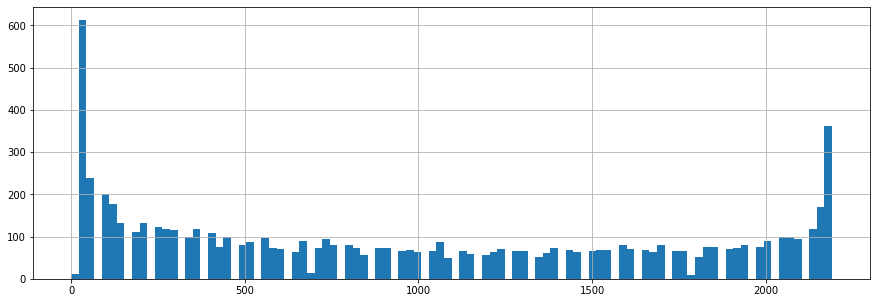

In [14]:
df_contract['count_day'].hist(bins=100,figsize=(15,5))

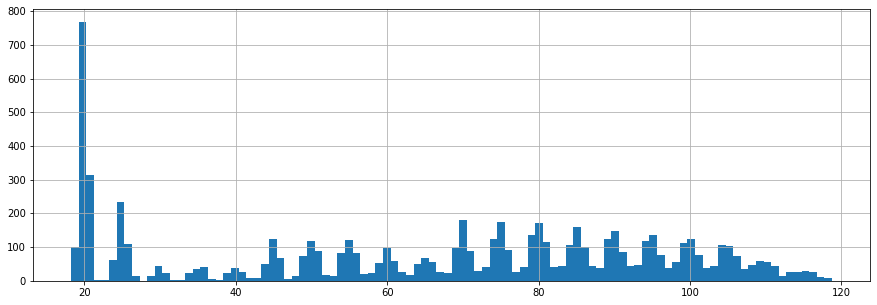

In [15]:
df_contract.MonthlyCharges.hist(bins=100, figsize=(15,5))

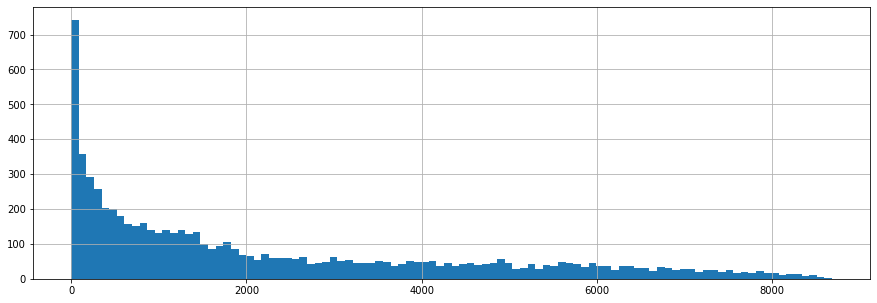

In [16]:
df_contract.TotalCharges.hist(bins=100, figsize=(15,5))

In [17]:
df_contract[df_contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,lost,count_day
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.0,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.0,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.0,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0.0,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0.0,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0.0,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0.0,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0.0,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0.0,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0.0,0,0


In [18]:
# Делаем полное объединение df_contract и df_personal по id абонента
df = df_contract.merge(df_personal, on=['customerID'], how='outer')

In [19]:
# Объединим общую таблицу с df_internet и df_phone левым соединением
df = df.merge(df_internet, on=['customerID'], how='left')
df = df.merge(df_phone, on=['customerID'], how='left')

In [20]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
lost                   0
count_day              0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [21]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,lost,count_day,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,Fiber optic,No,No,No,No,No,No,No


# Вывод:

- Датасеты объединены в один.
- Подготовлен целевой признак **lost**.
- Добавлен новый признак **время продолжительности договора в днях (count_day)**, на основании BeginDate.
- Признаки приведены к нужному типу данных.


## Исследовательский анализ данных. Построение графиков

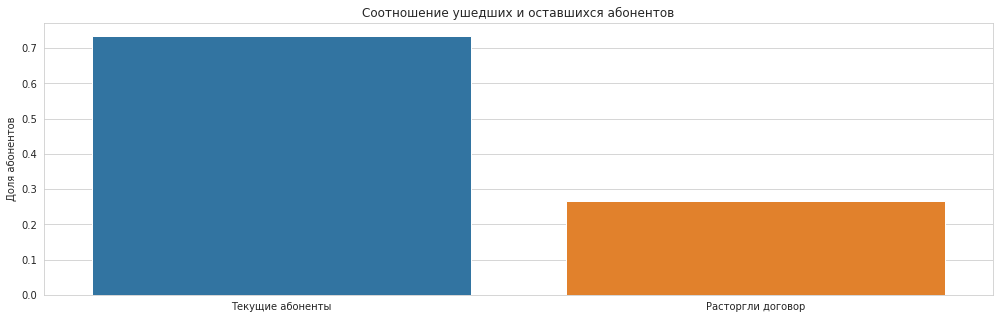

In [22]:
fig = plt.figure(figsize=(17, 5))
sns.set_style('whitegrid')
sns.barplot(x=[0, 1], y=df.lost.value_counts() / df.shape[0])
plt.xticks(range(2), ['Текущие абоненты', 'Расторгли договор'])
plt.title('Соотношение ушедших и оставшихся абонентов')
plt.ylabel('Доля абонентов')
plt.show()

Около 25% абонетов ушло.

---

Кол-во ушедших абонентов по месяцам.

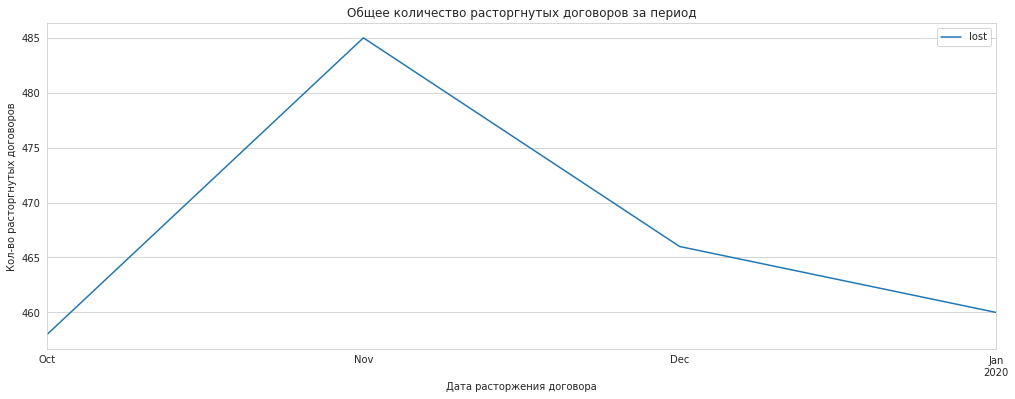

In [23]:
(
    df[df['EndDate'] != '2020-02-01']
    .pivot_table(index='EndDate', values='lost', aggfunc=('sum'))
    .sort_values('EndDate')
    .plot(grid=True,figsize=(17, 6)))

plt.title('Общее количество расторгнутых договоров за период')
plt.ylabel('Кол-во расторгнутых договоров')
plt.xlabel('Дата расторжения договора')
plt.show()

Представлен маленький временной период, сложно говорить о сезонности. Необходимо больше данных, несколько лет. Мы получили срок действия договора, при обучении необходимо избавиться от данного признака.

---

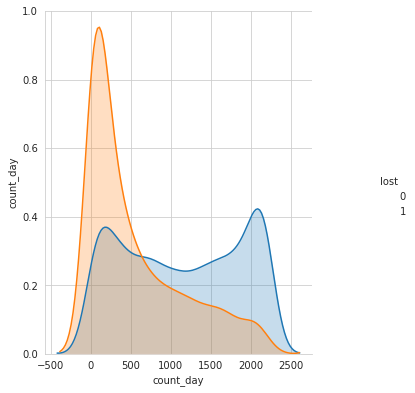

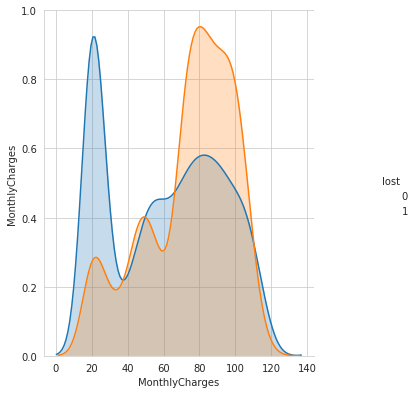

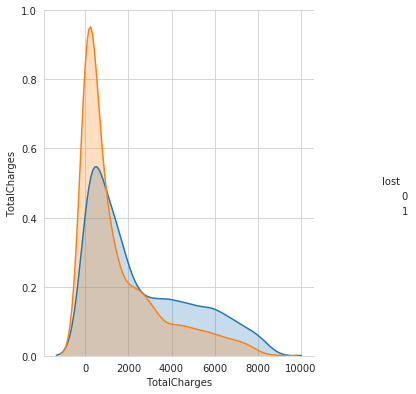

In [24]:
for i in ['count_day','MonthlyCharges','TotalCharges']:
    g=sns.pairplot(df, vars=[i], hue='lost')
    g.fig.set_size_inches(7,7)
plt.show()

- Новые абоненты чаше всего отказываются.
- Можно проследить тенденцию ушедших абонентов при небольшой суммы оплаты.

---

Процент суммовых потерь от общего кол-ва оплат

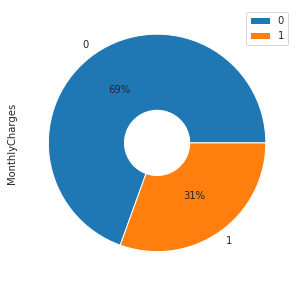

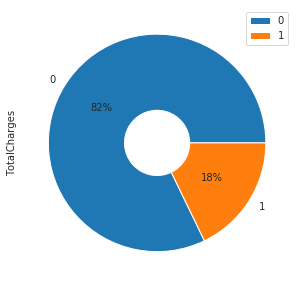

In [25]:
for i in ['MonthlyCharges', 'TotalCharges']:
    (
        df.pivot_table(index = 'lost', values = [i], aggfunc = 'sum').
        sort_values([i], ascending = False).
        plot(y = [i], 
             wedgeprops=dict(width=0.7), 
             kind = 'pie', 
             label = [i], 
             autopct='%1.0f%%',
             figsize=(17, 5)))


    plt.show()

18% доля ушедших от общего количества платежей и 31% ежемесячных платежей

# Вывод

Просматривается тенденция ушедших абонентов при небольшой суммы оплаты. Новые абоненты чаше всего отказываются от договора.

## Подготовить данные для обучения

### Преобразование категориальных признаков

In [26]:
# Заполним пустые признаки.
df = df.fillna('No') 

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
lost                7043 non-null int64
count_day           7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines    

In [28]:
# Удаляем даты и ID.
data = df.drop(['BeginDate','EndDate', 'customerID'], axis=1)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
lost                7043 non-null int64
count_day           7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines       7043 non-null object
dtypes: float64(2), int64(3), object(14)
memory usage: 1.4+ MB


Выделим категориальные признаки для преобразования в численные, кроме (SeniorCitizen):

In [30]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']

In [31]:
categorical_columns

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

Выделим бинарные и небинарные признаки:

In [32]:
binary_columns    = [c for c in categorical_columns if len(data[c].unique()) == 2]
nonbinary_columns = [c for c in categorical_columns if len(data[c].unique()) > 2]
binary_columns, nonbinary_columns

(['PaperlessBilling',
  'gender',
  'Partner',
  'Dependents',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'MultipleLines'],
 ['Type', 'PaymentMethod', 'InternetService'])

У бинарных признаков изменим значения на 1 и 0.

In [33]:
data_describe = data.describe(include=[object])
data_describe

,Type,PaperlessBilling,PaymentMethod,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,3,2,4,2,2,2,3,2,2,2,2,2,2,2
top,Month-to-month,Yes,Electronic check,Male,No,No,Fiber optic,No,No,No,No,No,No,No
freq,3875,4171,2365,3555,3641,4933,3096,5024,4614,4621,4999,4336,4311,4072


In [34]:
binary_columns

['PaperlessBilling',
 'gender',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [35]:
for c in binary_columns[0:]:
    top = data_describe[c]['top']
    top_items = data[c] == top
    data.loc[top_items, c] = 0
    data.loc[np.logical_not(top_items), c] = 1

In [36]:
data[binary_columns].describe()

,PaperlessBilling,gender,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.407781,0.495244,0.483033,0.299588,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.421837
std,0.491457,0.500013,0.499748,0.458110,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.493888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


К небинарными признакам применим метод векторизации

In [37]:
data = pd.get_dummies(data,drop_first=True)

In [38]:
data.head(5)

,PaperlessBilling,MonthlyCharges,TotalCharges,lost,count_day,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,...,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
0,0,29.85,29.85,0,31,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,56.95,1889.50,0,1036,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,0,53.85,108.15,1,61,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,42.30,1840.75,0,1371,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,70.70,151.65,1,61,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
PaperlessBilling                         7043 non-null int64
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
lost                                     7043 non-null int64
count_day                                7043 non-null int64
gender                                   7043 non-null int64
SeniorCitizen                            7043 non-null int64
Partner                                  7043 non-null int64
Dependents                               7043 non-null int64
OnlineSecurity                           7043 non-null int64
OnlineBackup                             7043 non-null int64
DeviceProtection                         7043 non-null int64
TechSupport                              7043 non-null int64
StreamingTV                              7043 non-null int64
StreamingMovies                    

### Разбеение данных на выборки.

In [40]:
target = data['lost']
features = data.drop(['lost'],axis=1)

In [41]:
# Разделение на валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target,
                                                                              stratify=target,
                                                                              test_size=0.20, 
                                                                              random_state=12345)

In [42]:
# Разделение на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features_train, 
                                                                            target_train,
                                                                            stratify=target_train,
                                                                            test_size=0.25, 
                                                                            random_state=12345)

In [43]:
# Проверка доли целевого признака
def chek_stratify(data, namedata):
    print("Доля ушедших клиентов для",namedata,"выборки: {:.2%}".format(data.sum()/len(data)))

In [44]:
chek_stratify(target_train,"обучающей")
chek_stratify(target_valid,"валидационной")
chek_stratify(target_test,"тестовой")

Доля ушедших клиентов для обучающей выборки: 26.53%
Доля ушедших клиентов для валидационной выборки: 26.54%
Доля ушедших клиентов для тестовой выборки: 26.54%


In [45]:
print(target_train.shape, target_valid.shape, target_test.shape)

(4225,) (1409,) (1409,)


In [46]:
x_col = ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'count_day',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No']

cat_features = ['PaperlessBilling', 'gender', 'Partner', 
                'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
                'Type_One year', 'Type_Two year', 'PaymentMethod_Credit card (automatic)',
                'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
                'InternetService_Fiber optic', 'InternetService_No', 'SeniorCitizen']

y_col = ['lost']

Увеличим обучающую выборку.

Преобразование проходит в несколько этапов:
 * Разделить обучающую выборку на отрицательные и положительные объекты;
 * Скопировать несколько раз положительные объекты;
 * С учётом полученных данных создать новую обучающую выборку;
 * Перемешать данные: идущие друг за другом

In [47]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

#features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
features_train, target_train = upsample(features_train, target_train, 3)

In [48]:
features_train.shape[0]

6467

# Вывод

- Бинарные признаки заменены на 1 и 0. К остальным не бинарными признакам применен метод векторизации;
- Разделены данные на 3 выборки: обучающую, вариационную и тестовую;
- Увеличена обучающая выборка, для борьбы с дисбалансом;

## Модель

In [49]:
general_table = {}

def base_fit(model, name: str):

    model.fit(features_train, target_train)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]    
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    accuracy = accuracy_score(model.predict(features_valid), target_valid)
    matrix = confusion_matrix(model.predict(features_valid), target_valid)
    classification = classification_report(model.predict(features_valid), target_valid) 
    
    print(classification)
    print(" ")
    print('Confusion Metrix:')
    print(matrix)
    print(" ")
    print('roc_auc', roc_auc)
    print(" ")
    print('accuracy', accuracy)

    general_table.update({name:roc_auc})

### DecisionTreeClassifier

In [50]:
model_DecisionTreeClassifier = GridSearchCV(DecisionTreeClassifier(random_state=12345),
                                            param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                                                        'max_depth': [10,50,100,500]},
                                                        #'class_weight': ['balanced']},
                                            cv=5, 
                                            scoring='roc_auc')

In [51]:
base_fit(model_DecisionTreeClassifier,'DecisionTreeClassifier')

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1049
           1       0.51      0.53      0.52       360

    accuracy                           0.75      1409
   macro avg       0.68      0.68      0.68      1409
weighted avg       0.75      0.75      0.75      1409

 
Confusion Metrix:
[[867 182]
 [168 192]]
 
roc_auc 0.6771409749670619
 
accuracy 0.751596877217885


### RandomForestClassifier

In [52]:
model_RandomForestClassifier = GridSearchCV(RandomForestClassifier(random_state=12345), 
                                            param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                                                        'max_depth': [10,50,100,500],
                                                        'n_estimators': [10,50,100,]},
                                                        #'class_weight': ['balanced']}, 
                                            cv=5, 
                                            scoring='roc_auc')

In [53]:
base_fit(model_RandomForestClassifier, 'RandomForestClassifier')

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1030
           1       0.63      0.62      0.62       379

    accuracy                           0.80      1409
   macro avg       0.74      0.74      0.74      1409
weighted avg       0.80      0.80      0.80      1409

 
Confusion Metrix:
[[890 140]
 [145 234]]
 
roc_auc 0.8372316515539022
 
accuracy 0.7977288857345636


### XGBClassifier

In [54]:
model_XGBClassifier = GridSearchCV(XGBClassifier(random_state=12345), 
                  param_grid={'max_depth': range(5, 11),
                              'learning_rate': np.arange(.4, 1.4, .1)},
                  cv=5, 
                  scoring='roc_auc')

In [55]:
base_fit(model_XGBClassifier,'XGBClassifier')

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1064
           1       0.65      0.70      0.67       345

    accuracy                           0.83      1409
   macro avg       0.77      0.79      0.78      1409
weighted avg       0.84      0.83      0.84      1409

 
Confusion Metrix:
[[932 132]
 [103 242]]
 
roc_auc 0.8752008576816761
 
accuracy 0.8332150461320085


In [56]:
probabilities_test = model_XGBClassifier.predict_proba(features_test) 
probabilities_one_test = probabilities_test[:, 1] 

print('Accuracy',accuracy_score(model_XGBClassifier.predict(features_test), target_test))
print('Roc_auc',roc_auc_score(target_test,probabilities_one_test))
print('F1', f1_score(model_XGBClassifier.predict(features_test), target_test))

Accuracy 0.8410220014194464
Roc_auc 0.8844467694851327
F1 0.6948228882833788


In [70]:
confusion_matrix(model_XGBClassifier.predict(features_test), target_test)

array([[930, 119],
       [105, 255]])

Хороший результат. Но дальше CatBoost

### CatBoostClassifier

In [57]:
model_CatBoostClassifier = CatBoostClassifier(random_state=12345, 
                                              iterations=200,
                                              learning_rate=0.3,
                                              eval_metric='AUC',
                                              cat_features=cat_features,
                                              depth = 5,
                                              early_stopping_rounds= 50,
                                              verbose = 0)

In [58]:
base_fit(model_CatBoostClassifier,'CatBoostClassifier')

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       998
         1.0       0.75      0.69      0.72       411

    accuracy                           0.84      1409
   macro avg       0.81      0.80      0.80      1409
weighted avg       0.84      0.84      0.84      1409

 
Confusion Metrix:
[[906  92]
 [129 282]]
 
roc_auc 0.8948539099434241
 
accuracy 0.8431511710432931


Посмотрим посмотрим лучшее значения метрики.

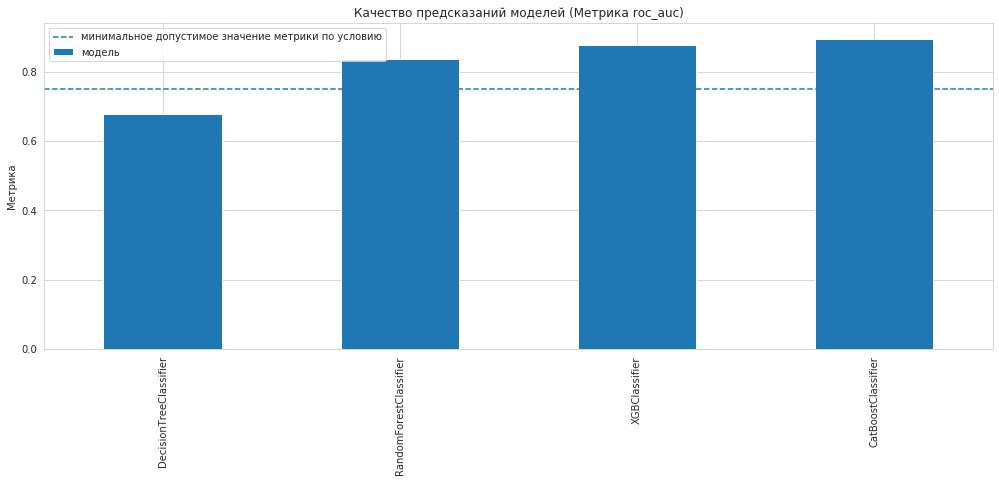

In [59]:
pd.Series(general_table).plot(grid=True,figsize=(17, 6),kind='bar',label = 'модель')
plt.axhline(0.75, xmin=0, xmax=1, linestyle = '--',label = 'минимальное допустимое значение метрики по условию')
plt.title('Качество предсказаний моделей (Метрика roc_auc)')
plt.ylabel('Метрика')
plt.legend()
plt.show()

Лучше всех себя показала CatBoostClassifier,показал лучший результат ROC_AUC  0.88764. Попробуем ещё немного улучшить качество модели используя eval_set.

In [60]:
model_CatBoostClassifier.fit(features_train, target_train, eval_set = (features_valid, target_valid))

In [61]:
probabilities_valid = model_CatBoostClassifier.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1] 
roc_auc_score(target_valid,probabilities_one_valid)

0.8957038414838926

In [62]:
confusion_matrix(model_CatBoostClassifier.predict(features_valid), target_valid)

array([[901,  89],
       [134, 285]])

Достигнутое значение ROC_AUC 0.8957.

In [63]:
fi = pd.DataFrame({'w':model_CatBoostClassifier.feature_importances_, 'name':features_train.columns})

In [64]:
fi.sort_values('w', ascending=False)

,w,name
3,48.651053,count_day
2,12.455354,TotalCharges
1,11.921195,MonthlyCharges
16,2.920670,Type_Two year
20,2.784760,InternetService_Fiber optic
15,2.045418,Type_One year
4,2.019897,gender
14,1.782545,MultipleLines
18,1.722652,PaymentMethod_Electronic check
0,1.499837,PaperlessBilling


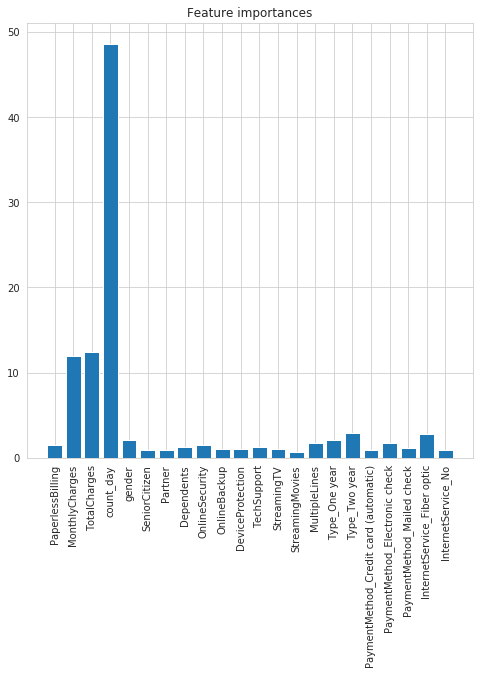

In [65]:
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(np.array(features_train.columns), model_CatBoostClassifier.feature_importances_, align='center')
plt.xticks(np.array(features_train.columns), rotation=90)
plt.xlim();

## Тестирование модели и вывод

Тестируем нашу модель на тестовой выборке

In [66]:
probabilities_test = model_CatBoostClassifier.predict_proba(features_test) 
probabilities_one_test = probabilities_test[:, 1] 

print('Accuracy',accuracy_score(model_CatBoostClassifier.predict(features_test), target_test))
print('Roc_auc',roc_auc_score(target_test,probabilities_one_test))
print('F1', f1_score(model_CatBoostClassifier.predict(features_test), target_test))

Accuracy 0.8516678495386799
Roc_auc 0.9150649719703428
F1 0.7317073170731707


In [67]:
confusion_matrix(model_CatBoostClassifier.predict(features_test), target_test)

array([[915,  89],
       [120, 285]])

In [68]:
q = confusion_matrix(model_CatBoostClassifier.predict(features_test), target_test)
print(" {:.2%}".format((q[1][0]) /  (q[0][0] + q[1][0])))
print(" {:.2%}".format((q[1][1]) / (q[1][1] + q[0][1])))

 11.59%
 76.20%


In [69]:
print(classification_report(model_CatBoostClassifier.predict(features_test), target_test))

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      1004
         1.0       0.76      0.70      0.73       405

    accuracy                           0.85      1409
   macro avg       0.82      0.81      0.81      1409
weighted avg       0.85      0.85      0.85      1409



Вывод:

Как показывает Accuracy на тестовой выборке с 85% существует вероятность, что модель правильно классифицирует пользователя. По условию задачи, метрику Roc_auc необходимо было получить больше 0,75, у нас 0.91.

## Отчет

# Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты плана были выполнены.

# Какие трудности возникли и как вы их преодолели?
Проблемы были с построениями графиков в исследовательском анализе. Не знал, как лучше построить графики для хорошей визуализации. Путем многократного построения различных графиков вывел для себя графики с наилучшей визуализацией. 


# Какие ключевые шаги в решении задачи выделили?
- Анализ данных;
- Создание нового признака;
- Предобработка данных
 - Объеденение датасетов
 - Подготовка целевого признака из EndDate
 - Добавлен новый признак время продолжительности договора в днях.
 - Изменён тип данных у BeginDate, EndDate, TotalCharges в df_contract.
- Преобразование категориальных признаков
- Баланс классов
- Подбор гиперпараметров модели с помощью GridSearchCV.

В обучении модели не участвовали следующие признаки: 'BeginDate','EndDate', 'customerID'.
Основные признаки при обучении: count_day, TotalCharges, MonthlyCharges, Type_Two year, InternetService_Fiber optic, Type_One year




# Какая ваша итоговая модель и какое у неё качество?
CatBoost показал Roc_auc 0.91. XGBClassifier тоже показывает хороший Roc_auc. На тестовой выборке 0.8844. 
Предпочтение отдам XGBClassifier, т.к. данная модель лидер по истине положительным ответам, что является основным фактом при постановке задачи.


###### Комментарий от тимлида

Привет! Все отлично.